In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from ephysvibe.trials.spikes import firing_rate,sp_constants
# from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.task import def_task,task_constants
from collections import defaultdict
from typing import Dict
from ephysvibe.structures.trials_data import TrialsData
import os 

In [2]:
from sklearn.preprocessing import MinMaxScaler

In [3]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],d_shape[1],int(np.floor(d_shape[2]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[2]-step,step):
        d_avg[:,:,count] = np.mean(data[:,:,i_step:i_step+win],axis=2)
        count +=1
    return d_avg

In [98]:
filepath ="/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/v4/2023-01-20_11-00-24_Riesling_v4_e1_r1.h5"
s_path = os.path.normpath(filepath).split(os.sep)
data = TrialsData.from_python_hdf5(filepath)

In [99]:
#b1 = np.where(data.block == 1)[0][0]
#trial_idx = np.where(data.trial_error[b1:] == 0)[0] 

In [100]:
# Select trials and create task frame
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
task = def_task.create_task_frame(
    condition=data.condition[trial_idx],
    test_stimuli=data.test_stimuli[trial_idx],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)

cgroup = "all"
in_out='in'

if cgroup == 'all':
    neurons = np.where(data.clustersgroup != cgroup)[0]
else:
    neurons = np.where(data.clustersgroup == cgroup)[0]
print("Number of clusters: %d" % len(data.clustersgroup))
print("Number of %s units: %d" % (cgroup, len(neurons)))


task=task[task['in_out']==in_out]
sample = "o1"
sample_a = "11.0"
sample_b = '15.0'
task = task.loc[task['sample'].str.contains(sample, case=False)]
task = task[task['n_test_stimuli']!=1]

Number of clusters: 32
Number of all units: 32


In [111]:

# split in two groups where the neurons in each have the same trials in in or out
task_1 = task[task['i_neuron']==neurons[0]]
trials_neuron = task_1['trial_idx'].values
#task_1['trial_idx'] = task_1['trial_idx'].replace(trials_neuron,np.arange(0,len(trials_neuron)))
t_neurons = task[np.in1d(task['trial_idx'].values,trials_neuron)]['i_neuron'].unique()
t_neurons_2=neurons[~np.in1d(neurons,t_neurons)]
task_all = [task_1]
if len(t_neurons_2) != 0:
    trials_neuron_2 = task[task['i_neuron']==t_neurons_2[0]]['trial_idx'].values
    trials_neuron = [trials_neuron,trials_neuron_2]
    t_neurons = [t_neurons,t_neurons_2]
    task_2 = task[task['i_neuron']==t_neurons_2[0]]

    task_all = [task_1,task_2]
else:
    trials_neuron = [trials_neuron]
    t_neurons = [t_neurons]


d_avg:Dict[str,list] = defaultdict(list)
for  trial_idx_n, i_neurons,i_task in zip(trials_neuron,t_neurons,task_all):
    
    test_stimuli=np.array(data.test_stimuli[trial_idx[trial_idx_n]],dtype=str)
    # ! fix np.logical_or(test_stimuli=='11.0',test_stimuli=='51.0')
    test_stimuli = np.where(np.logical_or(test_stimuli==sample_a,test_stimuli==sample_b),'nan',test_stimuli) 
    sp =data.sp_samples[trial_idx[trial_idx_n]][:,i_neurons]
    all_avg_sp = moving_average(data=np.array(sp),win=50, step=1)
    max_n = np.nanmax(all_avg_sp,axis=(0,2))
    min_n = np.nanmin(all_avg_sp,axis=(0,2))
    for color in range(1,9):
        rows, cols = np.where(np.char.find(test_stimuli,str(color),start=1)==1) # the rows are the trials and columns the n test stimuli
        code_numbers = data.code_numbers[trial_idx[trial_idx_n]] 
        code_samples = data.code_samples[trial_idx[trial_idx_n]] 
        _, cols_code = np.where(code_numbers == task_constants.EVENTS_B1['test_on_1'])
        code_numbers = code_numbers[:,cols_code[0]:]
        timestamps = np.array(code_samples[rows,cols],dtype=int)
        sp_trials = []

        
        
        for i_trial,i_ts in zip(rows,timestamps):
            sp_trials.append(sp[i_trial,:,i_ts-50:i_ts+500])
        avg_sp = moving_average(data=np.array(sp_trials),win=50, step=1)

        a=avg_sp-min_n[None,:,None]

        avg_sp= a/np.where(max_n-min_n == 0,1,max_n-min_n)[None,:,None]
        avg_sp = np.concatenate(avg_sp,axis=0)
        d_avg[str(color)]+=avg_sp.tolist()
      

/tmp/ipykernel_71207/2483431204.py:23: RuntimeWarning: invalid value encountered in cast
  test_stimuli=np.array(data.test_stimuli[trial_idx[trial_idx_n]],dtype=str)


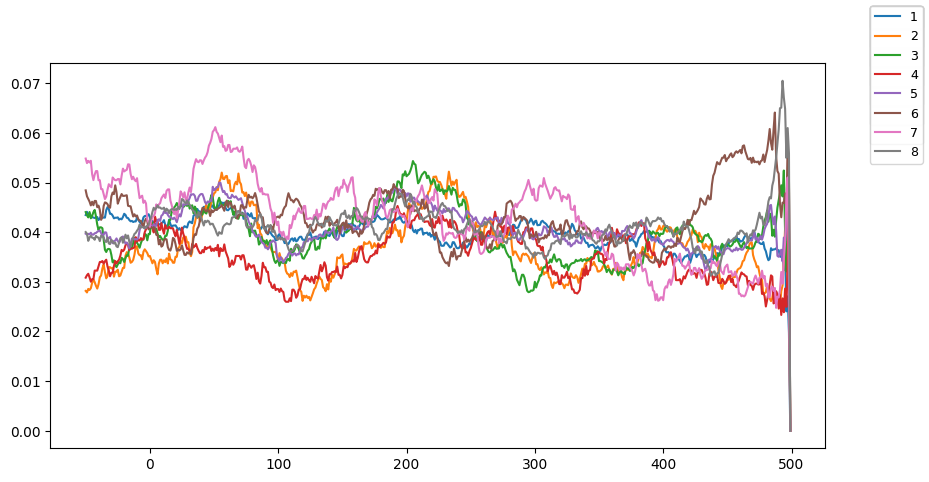

In [117]:
fig, ax = plt.subplots(figsize = (10,5))
for color in d_avg.keys():

    y = np.array(d_avg[color]).mean(axis=0)
    ax.plot(np.arange(-50,len(y)-50),y,label=color)
    fig.legend(fontsize=9)

In [115]:
i_ts

1015